In [25]:
# Cell 0: Dataset preparation & setup

import subprocess, sys
from pathlib import Path

# 1) Locate project root by finding 'subblock_detect' folder
cwd = Path().resolve()
for p in [cwd] + list(cwd.parents):
    if (p / "subblock_detect").is_dir():
        proj_root = p
        break
else:
    raise FileNotFoundError("Could not find project root containing 'subblock_detect/'")

# 2) Run the prepare_subblock_dataset.py script
prep_script = proj_root / "subblock_detect" / "scripts" / "prepare_subblock_dataset.py"
print(f"⏳ Running dataset prep script at {prep_script}")
proc = subprocess.run([sys.executable, str(prep_script)],
                      cwd=str(proj_root),
                      capture_output=True, text=True)
print("STDOUT:\n", proc.stdout)
print("STDERR:\n", proc.stderr)
if proc.returncode != 0:
    raise RuntimeError("Dataset preparation failed; see STDERR above.")

# 3) Ensure trained_models/ directory exists
trained_dir = proj_root / "trained_models"
trained_dir.mkdir(exist_ok=True)
print(f"✅ Prepared dataset and ensured trained_models directory at {trained_dir}")


⏳ Running dataset prep script at /Users/fatihbasturk/Projects/EE58A-2025/subblock_detect/scripts/prepare_subblock_dataset.py
STDOUT:
 Found 193 JSON files in /Users/fatihbasturk/Projects/EE58A-2025/subblock_detect/data/to_label_images
Generated 193 YOLO label files in /Users/fatihbasturk/Projects/EE58A-2025/subblock_detect/labels/to_label
Preparing splits for 193 labeled images
 -> train: 154 images
 -> val: 19 images
 -> test: 20 images
✅ Dataset preparation complete. YAML written to /Users/fatihbasturk/Projects/EE58A-2025/subblock_detect/config/subblock_data.yaml

STDERR:
 
✅ Prepared dataset and ensured trained_models directory at /Users/fatihbasturk/Projects/EE58A-2025/trained_models


# Sub-Block Detection Experiment

- **Dataset**: `subblock_detect/subblock_dataset` split into train/val/test  
- **Classes**: `differential_pair`, `cascade`, `current_mirror`  
- **Ratios**: computed automatically from folder counts  

We will:

1. Train Stage 1 (freeze=10) for 30 epochs  
2. Train Stage 2 (freeze=0) for 20 epochs  
3. Extract & plot per-epoch losses and mAP@0.5  
4. Compute final per-class AP for each stage  
5. Display results in tables & bar charts  


## Monitoring Model Performance: mAP Curve

We track **mean Average Precision (mAP)** at IoU = 0.5 over the course of training to see how quickly and how well the model learns to localize and classify our three sub-block classes:  
- **differential_pair**  
- **cascade**  
- **current_mirror**  

The **mAP@0.5 curve** is plotted with epoch on the x-axis and mAP on the y-axis.  
- A **rising curve** indicates the model is improving.  
- **Plateaus** suggest learning has saturated.  
- **Sudden jumps** (often at the start of Stage 2) show the benefit of unfreezing the backbone.

Below we overlay Stage 1 (head-only) and Stage 2 (full fine-tune) curves for easy comparison.

---

### Per-Class Precision, Recall & AP Table

We compute for each of our 3 sub-block classes:
- **Precision**: TP / (TP + FP) at IoU=0.5  
- **Recall**   : TP / (TP + FN) at IoU=0.5  
- **AP@0.5**   : Area under the PR curve at IoU=0.5  
- **AP@0.5–0.95**: Average AP across IoUs 0.5→0.95  

This table helps identify which classes the model confuses (low precision) or misses (low recall).


In [26]:
# Cell 1: Imports, Configuration & Utilities

import yaml
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from ultralytics import YOLO

# 1) Project root already found in Cell 0, reuse:
#    proj_root, trained_dir

# 2) Paths & hyperparameters
DATA_YAML   = str(proj_root / "subblock_detect" / "config" / "subblock_data.yaml")
ORIG_MODEL  = str(trained_dir   / "yolov8_original.pt")  # ensure you have placed your 12-class .pt here
DEVICE      = "mps"           # or 'cpu' / 'cuda:0'
STAGE1_NAME = "exp_stage1"
STAGE2_NAME = "exp_stage2"
EPOCHS1     = 30
EPOCHS2     = 20
IMG_SIZE    = 640
BATCH_SIZE  = 16

# 3) Control flags
RUN_STAGE1 = False   # set True to train stage1
RUN_STAGE2 = False   # set True to train stage2

# 4) Load class names from DATA_YAML
with open(DATA_YAML) as f:
    data_cfg = yaml.safe_load(f)
CLASS_NAMES = data_cfg["names"]
print("DATA_YAML:", DATA_YAML)
print("Classes:", CLASS_NAMES)

# 5) Utility to locate checkpoint
def get_checkpoint(run_name, best=True):
    wdir = proj_root / "runs" / "detect" / run_name / "weights"
    best_ckpt = wdir / "best.pt"
    last_ckpt = wdir / "last.pt"
    if best and best_ckpt.exists(): return str(best_ckpt)
    if last_ckpt.exists(): 
        print(f"⚠️ best.pt not found for {run_name}, using last.pt")
        return str(last_ckpt)
    raise FileNotFoundError(f"No checkpoint for run {run_name}")

def load_metrics(run_name):
    """
    Load the Ultralytics results.csv for a given run.
    """
    path = proj_root / "runs" / "detect" / run_name / "results.csv"
    if not path.exists():
        raise FileNotFoundError(f"{path} not found")
    df = pd.read_csv(path)
    # Rename columns to match expected keys
    df = df.rename(columns={"map50": "mAP50", "map50-95": "mAP50-95"})
    return df.set_index("epoch")

print("load_metrics now reads results.csv")


DATA_YAML: /Users/fatihbasturk/Projects/EE58A-2025/subblock_detect/config/subblock_data.yaml
Classes: ['differential_pair', 'cascode', 'current_mirror']
load_metrics now reads results.csv


In [27]:
# Cell 2: Stage 1 Training & Artifact Saving

from ultralytics import YOLO
import shutil

# 1) Initialize model
model1 = YOLO(ORIG_MODEL)

# 2) Train (if flag enabled)
if RUN_STAGE1:
    print(f"▶️ Starting Stage 1 training for {EPOCHS1} epochs…")
    stage1 = model1.train(
        data=DATA_YAML,
        epochs=EPOCHS1,
        imgsz=IMG_SIZE,
        batch=BATCH_SIZE,
        freeze=10,
        device=DEVICE,
        name=STAGE1_NAME,
        save=True,
        exist_ok=True,
        verbose=False,
        max_det=100
    )
    print("✅ Stage 1 training complete.")
else:
    print("⏭️ Skipping Stage 1 training (RUN_STAGE1=False)")

# 3) Copy out best.pt and metrics.csv to trained_models/
try:
    ckpt1 = get_checkpoint(STAGE1_NAME)
    dst_w = trained_dir / f"{STAGE1_NAME}_best.pt"
    shutil.copy2(ckpt1, dst_w)
    print(f"✅ Copied Stage1 weights → {dst_w}")

    src_m = proj_root / "runs" / "detect" / STAGE1_NAME / "metrics.csv"
    dst_m = trained_dir / f"{STAGE1_NAME}_metrics.csv"
    shutil.copy2(src_m, dst_m)
    print(f"✅ Copied Stage1 metrics → {dst_m}")
except FileNotFoundError as e:
    print(f"⚠️ Artifact copy skipped: {e}")


⏭️ Skipping Stage 1 training (RUN_STAGE1=False)
✅ Copied Stage1 weights → /Users/fatihbasturk/Projects/EE58A-2025/trained_models/exp_stage1_best.pt
⚠️ Artifact copy skipped: [Errno 2] No such file or directory: '/Users/fatihbasturk/Projects/EE58A-2025/runs/detect/exp_stage1/metrics.csv'


In [28]:
# Cell 3: Stage 2 Training & Artifact Saving

from ultralytics import YOLO
import shutil

# 1) Locate the Stage 1 checkpoint (best or last)
stage1_ckpt = get_checkpoint(STAGE1_NAME)

# 2) Initialize model for Stage 2
model2 = YOLO(stage1_ckpt)

# 3) Train Stage 2 (if flag enabled)
if RUN_STAGE2:
    print(f"▶️ Starting Stage 2 fine-tune for {EPOCHS2} epochs…")
    stage2 = model2.train(
        data=DATA_YAML,
        epochs=EPOCHS2,
        imgsz=IMG_SIZE,
        batch=BATCH_SIZE,
        freeze=0,
        device=DEVICE,
        name=STAGE2_NAME,
        save=True,
        exist_ok=True,
        verbose=False,
        max_det=100
    )
    print("✅ Stage 2 training complete.")
else:
    print("⏭️ Skipping Stage 2 training (RUN_STAGE2=False)")

# 4) Copy out Stage2 artifacts
try:
    ckpt2 = get_checkpoint(STAGE2_NAME)
    dst_w2 = trained_dir / f"{STAGE2_NAME}_best.pt"
    shutil.copy2(ckpt2, dst_w2)
    print(f"✅ Copied Stage2 weights → {dst_w2}")

    src_m2 = proj_root / "runs" / "detect" / STAGE2_NAME / "metrics.csv"
    dst_m2 = trained_dir / f"{STAGE2_NAME}_metrics.csv"
    shutil.copy2(src_m2, dst_m2)
    print(f"✅ Copied Stage2 metrics → {dst_m2}")
except FileNotFoundError as e:
    print(f"⚠️ Artifact copy skipped: {e}")


⏭️ Skipping Stage 2 training (RUN_STAGE2=False)
✅ Copied Stage2 weights → /Users/fatihbasturk/Projects/EE58A-2025/trained_models/exp_stage2_best.pt
⚠️ Artifact copy skipped: [Errno 2] No such file or directory: '/Users/fatihbasturk/Projects/EE58A-2025/runs/detect/exp_stage2/metrics.csv'


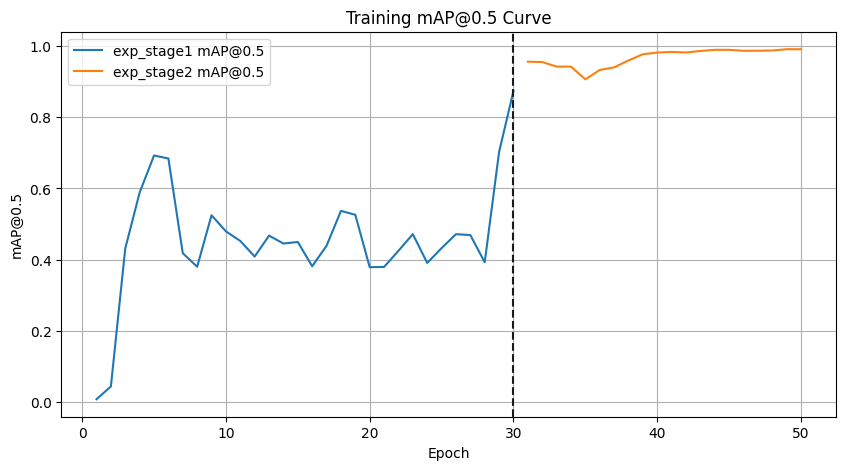

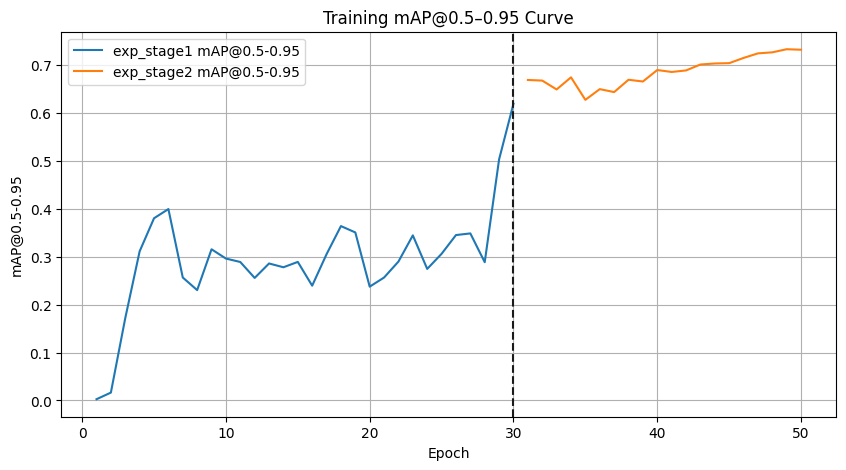

In [29]:
# Cell 4e: Plot using actual column names from results.csv

# Load metrics
df1 = load_metrics(STAGE1_NAME)
df2 = load_metrics(STAGE2_NAME)

# Use the correct column names
map50_col   = "metrics/mAP50(B)"
map5095_col = "metrics/mAP50-95(B)"

# Plot mAP@0.5 over epochs
plt.figure(figsize=(10,5))
plt.plot(df1.index, df1[map50_col], label=f"{STAGE1_NAME} mAP@0.5")
plt.plot(df2.index + df1.index.max(),
         df2[map50_col], label=f"{STAGE2_NAME} mAP@0.5")
plt.xlabel("Epoch")
plt.ylabel("mAP@0.5")
plt.title("Training mAP@0.5 Curve")
plt.legend()
plt.grid(True)
plt.axvline(x=df1.index.max(), color='k', linestyle='--', label='Stage switch')

plt.show()

# Plot mAP@0.5–0.95 over epochs
plt.figure(figsize=(10,5))
plt.plot(df1.index, df1[map5095_col], label=f"{STAGE1_NAME} mAP@0.5-0.95")
plt.plot(df2.index + df1.index.max(),
         df2[map5095_col], label=f"{STAGE2_NAME} mAP@0.5-0.95")
plt.xlabel("Epoch")
plt.ylabel("mAP@0.5-0.95")
plt.title("Training mAP@0.5–0.95 Curve")
plt.legend()
plt.grid(True)
plt.axvline(x=df1.index.max(), color='k', linestyle='--', label='Stage switch')

plt.show()


In [30]:
# Cell 7: Parameter Sweep with Dry‐Run Check

import shutil

# Flag: first pass with 1 epoch to verify execution, then set False for full runs
DRY_RUN = False
DRY_EPOCHS = 1
FULL_EPOCHS = EPOCHS2  # from your config above

# Base checkpoint (Stage 2 best)
base_ckpt = get_checkpoint(STAGE2_NAME)

# Parameter experiments
param_exps = [
    ("lr0_5e-4",    {"lr0": 5e-4}),
    ("wd_1e-3",     {"weight_decay": 1e-3}),
    ("mosaic_on",   {"close_mosaic": 0, "mosaic": 1.0}),
    ("cosine_lr",   {"cos_lr": True})
]

for tag, override in param_exps:
    run_name = f"exp_{tag}"
    epochs = DRY_EPOCHS if DRY_RUN else FULL_EPOCHS
    print(f"\n▶️ {'Dry-run' if DRY_RUN else 'Full'} training '{run_name}' for {epochs} epoch(s) with {override}")
    # train
    YOLO(base_ckpt).train(
        data=DATA_YAML,
        epochs=epochs,
        imgsz=IMG_SIZE,
        batch=BATCH_SIZE,
        freeze=0,
        device=DEVICE,
        name=run_name,
        save=True,
        exist_ok=True,
        verbose=False,
        max_det=100,
        **override
    )
    # copy out best (or last if best missing)
    ckpt = get_checkpoint(run_name)
    dst = trained_dir / f"{run_name}_best.pt"
    shutil.copy2(ckpt, dst)
    print(f"✅ Saved checkpoint to {dst}")

print("\n✅ All parameter‐sweep dry-runs complete. If it looks good, set DRY_RUN=False and rerun this cell for full training.")



▶️ Full training 'exp_lr0_5e-4' for 20 epoch(s) with {'lr0': 0.0005}
New https://pypi.org/project/ultralytics/8.3.131 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.122 🚀 Python-3.11.4 torch-2.6.0 MPS (Apple M4)
engine/trainer: task=detect, mode=train, model=/Users/fatihbasturk/Projects/EE58A-2025/runs/detect/exp_stage2/weights/best.pt, data=/Users/fatihbasturk/Projects/EE58A-2025/subblock_detect/config/subblock_data.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=mps, workers=8, project=None, name=exp_lr0_5e-4, exist_ok=True, pretrained=True, optimizer=auto, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=0, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=100, half=False, dnn=False, plots=True, source=None

train: Scanning /Users/fatihbasturk/Projects/EE58A-2025/subblock_detect/subblock_dataset/train/labels.cache... 193 images, 0 backgrounds, 0 corrupt: 100%|██████████| 193/193 [00:00<?, ?it/s]

val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 458.8±400.9 MB/s, size: 10.0 KB)



val: Scanning /Users/fatihbasturk/Projects/EE58A-2025/subblock_detect/subblock_dataset/val/labels... 102 images, 0 backgrounds, 0 corrupt: 100%|██████████| 102/102 [00:00<00:00, 9876.01it/s]

val: New cache created: /Users/fatihbasturk/Projects/EE58A-2025/subblock_detect/subblock_dataset/val/labels.cache
Plotting labels to /Users/fatihbasturk/Projects/EE58A-2025/runs/detect/exp_lr0_5e-4/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0005' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to /Users/fatihbasturk/Projects/EE58A-2025/runs/detect/exp_lr0_5e-4
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      5.79G      1.128      1.094      1.119          7        640: 100%|██████████| 13/13 [00:20<00:00,  1.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:14<00:00,  3.66s/it]

                   all        102        175      0.974       0.95      0.976      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      5.89G      1.159     0.9729      1.195          1        640: 100%|██████████| 13/13 [00:16<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:10<00:00,  2.68s/it]

                   all        102        175      0.984      0.958      0.979      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20       5.9G      1.061     0.9513      1.125          4        640: 100%|██████████| 13/13 [00:14<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.97s/it]

                   all        102        175       0.94      0.957      0.982      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      5.93G      1.076      1.004      1.125          1        640: 100%|██████████| 13/13 [00:15<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.86s/it]

                   all        102        175      0.945      0.967      0.985       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      5.99G      1.069     0.9975      1.141          3        640: 100%|██████████| 13/13 [00:14<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:10<00:00,  2.51s/it]

                   all        102        175      0.958      0.962      0.988      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      5.97G      1.089     0.9085      1.129          5        640: 100%|██████████| 13/13 [01:26<00:00,  6.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:13<00:00,  3.33s/it]


                   all        102        175      0.953      0.961      0.983      0.734

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      6.15G      1.098     0.9264      1.181          1        640: 100%|██████████| 13/13 [00:22<00:00,  1.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:09<00:00,  2.36s/it]

                   all        102        175      0.956      0.958      0.983      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      6.19G       1.04     0.9325      1.125          3        640: 100%|██████████| 13/13 [00:15<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.21s/it]

                   all        102        175      0.914      0.984      0.981      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      6.25G      1.064     0.9387      1.137          1        640: 100%|██████████| 13/13 [00:14<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:09<00:00,  2.26s/it]

                   all        102        175      0.962      0.919      0.982      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      6.25G      1.087     0.9806      1.163          4        640: 100%|██████████| 13/13 [00:15<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.11s/it]

                   all        102        175      0.949      0.974      0.987      0.711


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      6.25G     0.9621     0.7653      1.096          1        640: 100%|██████████| 13/13 [00:14<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:06<00:00,  1.74s/it]

                   all        102        175      0.939      0.971      0.984       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      6.33G     0.9356     0.6916       1.08          1        640: 100%|██████████| 13/13 [00:15<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.85s/it]

                   all        102        175      0.933      0.996      0.987      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20       6.4G     0.9749     0.6575      1.089          1        640: 100%|██████████| 13/13 [00:13<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:09<00:00,  2.29s/it]

                   all        102        175      0.947       0.99      0.991      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      6.45G     0.9088     0.6574      1.063          3        640: 100%|██████████| 13/13 [00:14<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:09<00:00,  2.25s/it]

                   all        102        175       0.97      0.958      0.987      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      6.47G     0.9491     0.6301      1.068          1        640: 100%|██████████| 13/13 [00:14<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.77s/it]

                   all        102        175      0.948      0.954      0.986      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      6.49G      0.858     0.5992      1.056          1        640: 100%|██████████| 13/13 [00:14<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.90s/it]

                   all        102        175      0.969      0.964      0.991       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      6.56G     0.8757     0.6032       1.06          1        640: 100%|██████████| 13/13 [00:14<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:06<00:00,  1.75s/it]


                   all        102        175      0.968      0.972      0.991      0.773

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      6.63G     0.8313     0.5932      1.019          3        640: 100%|██████████| 13/13 [00:13<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.04s/it]


                   all        102        175      0.978      0.972      0.993      0.777

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      6.64G     0.8343     0.5645      1.027          2        640: 100%|██████████| 13/13 [00:14<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.01s/it]


                   all        102        175      0.982      0.967      0.994      0.785

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      6.69G     0.8158     0.5694      1.019          1        640: 100%|██████████| 13/13 [00:13<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.20s/it]


                   all        102        175      0.975      0.986      0.995      0.788

20 epochs completed in 0.159 hours.
Optimizer stripped from /Users/fatihbasturk/Projects/EE58A-2025/runs/detect/exp_lr0_5e-4/weights/last.pt, 6.2MB
Optimizer stripped from /Users/fatihbasturk/Projects/EE58A-2025/runs/detect/exp_lr0_5e-4/weights/best.pt, 6.2MB

Validating /Users/fatihbasturk/Projects/EE58A-2025/runs/detect/exp_lr0_5e-4/weights/best.pt...
Ultralytics 8.3.122 🚀 Python-3.11.4 torch-2.6.0 MPS (Apple M4)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.05s/it]


                   all        102        175      0.975      0.986      0.995      0.788
Speed: 1.3ms preprocess, 13.9ms inference, 0.0ms loss, 8.3ms postprocess per image
Results saved to /Users/fatihbasturk/Projects/EE58A-2025/runs/detect/exp_lr0_5e-4
✅ Saved checkpoint to /Users/fatihbasturk/Projects/EE58A-2025/trained_models/exp_lr0_5e-4_best.pt

▶️ Full training 'exp_wd_1e-3' for 20 epoch(s) with {'weight_decay': 0.001}
New https://pypi.org/project/ultralytics/8.3.131 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.122 🚀 Python-3.11.4 torch-2.6.0 MPS (Apple M4)
engine/trainer: task=detect, mode=train, model=/Users/fatihbasturk/Projects/EE58A-2025/runs/detect/exp_stage2/weights/best.pt, data=/Users/fatihbasturk/Projects/EE58A-2025/subblock_detect/config/subblock_data.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=mps, workers=8, project=None, name=exp_wd_1e-3, exist_ok=True, pretrained=True, optimiz

train: Scanning /Users/fatihbasturk/Projects/EE58A-2025/subblock_detect/subblock_dataset/train/labels.cache... 193 images, 0 backgrounds, 0 corrupt: 100%|██████████| 193/193 [00:00<?, ?it/s]

val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 329.4±272.3 MB/s, size: 10.0 KB)



val: Scanning /Users/fatihbasturk/Projects/EE58A-2025/subblock_detect/subblock_dataset/val/labels.cache... 102 images, 0 backgrounds, 0 corrupt: 100%|██████████| 102/102 [00:00<?, ?it/s]

Plotting labels to /Users/fatihbasturk/Projects/EE58A-2025/runs/detect/exp_wd_1e-3/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to /Users/fatihbasturk/Projects/EE58A-2025/runs/detect/exp_wd_1e-3
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      6.78G      1.128      1.094      1.119          7        640: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.04it/s]

                   all        102        175      0.974       0.95      0.976      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      6.86G      1.159     0.9729      1.195          1        640: 100%|██████████| 13/13 [00:09<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.08it/s]

                   all        102        175      0.984      0.958      0.979      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      6.93G      1.061     0.9513      1.125          4        640: 100%|██████████| 13/13 [00:09<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.13it/s]


                   all        102        175       0.94      0.957      0.982      0.737

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20         7G      1.076      1.004      1.125          1        640: 100%|██████████| 13/13 [00:09<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


                   all        102        175      0.945      0.967      0.985       0.73

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      7.06G      1.069     0.9978      1.141          3        640: 100%|██████████| 13/13 [00:09<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.09it/s]


                   all        102        175      0.958      0.962      0.988      0.734

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      7.14G      1.089     0.9084      1.129          5        640: 100%|██████████| 13/13 [00:09<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.48s/it]


                   all        102        175      0.953      0.961      0.983      0.734

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20       7.2G      1.097     0.9261       1.18          1        640: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:06<00:00,  1.74s/it]


                   all        102        175      0.956      0.958      0.983      0.742

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      7.28G       1.04     0.9329      1.125          3        640: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.78s/it]

                   all        102        175      0.917       0.98       0.98      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      7.32G      1.061     0.9309      1.136          1        640: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:06<00:00,  1.63s/it]


                   all        102        175      0.941      0.941      0.981      0.741

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      7.35G      1.088     0.9796      1.164          4        640: 100%|██████████| 13/13 [00:09<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.88s/it]

                   all        102        175      0.949      0.959      0.988      0.709


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      7.37G     0.9592     0.7713      1.095          1        640: 100%|██████████| 13/13 [00:09<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


                   all        102        175      0.935      0.971      0.983      0.746

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      7.45G     0.9295     0.6892      1.079          1        640: 100%|██████████| 13/13 [00:09<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:06<00:00,  1.73s/it]


                   all        102        175      0.939      0.996      0.987       0.74

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      7.49G     0.9757     0.6479      1.087          1        640: 100%|██████████| 13/13 [00:08<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:06<00:00,  1.63s/it]


                   all        102        175      0.952      0.996      0.991      0.739

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      7.59G     0.9057     0.6474       1.06          3        640: 100%|██████████| 13/13 [00:08<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.17s/it]

                   all        102        175      0.971      0.945      0.987       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      7.62G     0.9504     0.6254      1.068          1        640: 100%|██████████| 13/13 [00:08<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:06<00:00,  1.73s/it]


                   all        102        175      0.967      0.954      0.986      0.755

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      7.65G     0.8635     0.6008      1.057          1        640: 100%|██████████| 13/13 [00:09<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.23s/it]


                   all        102        175      0.965       0.97      0.991      0.784

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      7.74G     0.8757     0.5991      1.058          1        640: 100%|██████████| 13/13 [00:08<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.85s/it]


                   all        102        175      0.967      0.974      0.992      0.777

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      7.81G     0.8321     0.5879      1.019          3        640: 100%|██████████| 13/13 [00:08<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:06<00:00,  1.58s/it]

                   all        102        175      0.979      0.974      0.993       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      7.85G     0.8336     0.5625      1.026          2        640: 100%|██████████| 13/13 [00:08<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


                   all        102        175      0.962      0.989      0.993      0.786

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      7.91G     0.8138     0.5701      1.019          1        640: 100%|██████████| 13/13 [00:09<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.76s/it]


                   all        102        175      0.962      0.989      0.993      0.788

20 epochs completed in 0.089 hours.
Optimizer stripped from /Users/fatihbasturk/Projects/EE58A-2025/runs/detect/exp_wd_1e-3/weights/last.pt, 6.2MB
Optimizer stripped from /Users/fatihbasturk/Projects/EE58A-2025/runs/detect/exp_wd_1e-3/weights/best.pt, 6.2MB

Validating /Users/fatihbasturk/Projects/EE58A-2025/runs/detect/exp_wd_1e-3/weights/best.pt...
Ultralytics 8.3.122 🚀 Python-3.11.4 torch-2.6.0 MPS (Apple M4)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.05s/it]


                   all        102        175      0.962       0.99      0.993      0.789
Speed: 0.7ms preprocess, 5.9ms inference, 0.0ms loss, 9.5ms postprocess per image
Results saved to /Users/fatihbasturk/Projects/EE58A-2025/runs/detect/exp_wd_1e-3
✅ Saved checkpoint to /Users/fatihbasturk/Projects/EE58A-2025/trained_models/exp_wd_1e-3_best.pt

▶️ Full training 'exp_mosaic_on' for 20 epoch(s) with {'close_mosaic': 0, 'mosaic': 1.0}
New https://pypi.org/project/ultralytics/8.3.131 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.122 🚀 Python-3.11.4 torch-2.6.0 MPS (Apple M4)
engine/trainer: task=detect, mode=train, model=/Users/fatihbasturk/Projects/EE58A-2025/runs/detect/exp_stage2/weights/best.pt, data=/Users/fatihbasturk/Projects/EE58A-2025/subblock_detect/config/subblock_data.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=mps, workers=8, project=None, name=exp_mosaic_on, exist_ok=True, pretrained=T

train: Scanning /Users/fatihbasturk/Projects/EE58A-2025/subblock_detect/subblock_dataset/train/labels.cache... 193 images, 0 backgrounds, 0 corrupt: 100%|██████████| 193/193 [00:00<?, ?it/s]

val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 584.9±81.5 MB/s, size: 10.0 KB)



val: Scanning /Users/fatihbasturk/Projects/EE58A-2025/subblock_detect/subblock_dataset/val/labels.cache... 102 images, 0 backgrounds, 0 corrupt: 100%|██████████| 102/102 [00:00<?, ?it/s]

Plotting labels to /Users/fatihbasturk/Projects/EE58A-2025/runs/detect/exp_mosaic_on/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to /Users/fatihbasturk/Projects/EE58A-2025/runs/detect/exp_mosaic_on
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      7.97G      1.128      1.094      1.119          7        640: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.16it/s]

                   all        102        175      0.974       0.95      0.976      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      8.05G      1.159     0.9729      1.195          1        640: 100%|██████████| 13/13 [00:09<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.15it/s]

                   all        102        175      0.984      0.958      0.979      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      8.11G      1.061     0.9513      1.125          4        640: 100%|██████████| 13/13 [00:09<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.16it/s]


                   all        102        175       0.94      0.957      0.982      0.737

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20       8.2G      1.076      1.004      1.125          1        640: 100%|██████████| 13/13 [00:09<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.19it/s]

                   all        102        175      0.945      0.967      0.985       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      8.22G      1.069     0.9975      1.141          3        640: 100%|██████████| 13/13 [00:09<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.14it/s]

                   all        102        175      0.958      0.962      0.988      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20       8.3G      1.089     0.9085      1.129          5        640: 100%|██████████| 13/13 [00:09<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.18it/s]


                   all        102        175      0.953      0.961      0.983      0.734

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      8.41G      1.098     0.9264      1.181          1        640: 100%|██████████| 13/13 [00:09<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.16it/s]

                   all        102        175      0.956      0.958      0.983      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      8.42G       1.04     0.9325      1.125          3        640: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.15it/s]

                   all        102        175      0.914      0.984      0.981      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      8.52G      1.064     0.9387      1.137          1        640: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.09it/s]

                   all        102        175      0.962      0.919      0.982      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      8.59G      1.087     0.9806      1.163          4        640: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.15it/s]

                   all        102        175      0.949      0.974      0.987      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      8.65G      1.038     0.8725      1.105          4        640: 100%|██████████| 13/13 [00:19<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.89s/it]

                   all        102        175      0.918      0.987      0.986      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20       8.7G      1.019     0.8817      1.105          7        640: 100%|██████████| 13/13 [00:17<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.95s/it]

                   all        102        175      0.969      0.971      0.991      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      8.75G      1.007     0.8515      1.077          3        640: 100%|██████████| 13/13 [00:16<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:06<00:00,  1.71s/it]


                   all        102        175      0.959      0.984      0.992      0.749

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      8.78G      1.013     0.8451       1.08          8        640: 100%|██████████| 13/13 [00:17<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:06<00:00,  1.69s/it]

                   all        102        175      0.943      0.999       0.99      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      8.82G      1.124     0.8619      1.182          4        640: 100%|██████████| 13/13 [00:18<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:06<00:00,  1.67s/it]


                   all        102        175      0.969      0.996      0.994       0.77

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      8.87G     0.9665     0.8426      1.085          1        640: 100%|██████████| 13/13 [00:17<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.10s/it]

                   all        102        175      0.968          1      0.993      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      8.95G     0.9505     0.8113      1.079          1        640: 100%|██████████| 13/13 [00:15<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.46s/it]

                   all        102        175      0.964      0.988      0.993      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      8.99G     0.9973     0.8837      1.093          8        640: 100%|██████████| 13/13 [00:15<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


                   all        102        175      0.957          1      0.993      0.775

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      9.05G      0.956     0.8666      1.093          5        640: 100%|██████████| 13/13 [00:16<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.99s/it]


                   all        102        175      0.958          1      0.993       0.78

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      9.08G     0.9424     0.8155      1.063          4        640: 100%|██████████| 13/13 [00:16<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


                   all        102        175      0.957          1      0.993      0.782

20 epochs completed in 0.105 hours.
Optimizer stripped from /Users/fatihbasturk/Projects/EE58A-2025/runs/detect/exp_mosaic_on/weights/last.pt, 6.2MB
Optimizer stripped from /Users/fatihbasturk/Projects/EE58A-2025/runs/detect/exp_mosaic_on/weights/best.pt, 6.2MB

Validating /Users/fatihbasturk/Projects/EE58A-2025/runs/detect/exp_mosaic_on/weights/best.pt...
Ultralytics 8.3.122 🚀 Python-3.11.4 torch-2.6.0 MPS (Apple M4)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.16it/s]


                   all        102        175      0.957          1      0.993      0.782
Speed: 0.4ms preprocess, 6.0ms inference, 0.0ms loss, 8.3ms postprocess per image
Results saved to /Users/fatihbasturk/Projects/EE58A-2025/runs/detect/exp_mosaic_on
✅ Saved checkpoint to /Users/fatihbasturk/Projects/EE58A-2025/trained_models/exp_mosaic_on_best.pt

▶️ Full training 'exp_cosine_lr' for 20 epoch(s) with {'cos_lr': True}
New https://pypi.org/project/ultralytics/8.3.131 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.122 🚀 Python-3.11.4 torch-2.6.0 MPS (Apple M4)
engine/trainer: task=detect, mode=train, model=/Users/fatihbasturk/Projects/EE58A-2025/runs/detect/exp_stage2/weights/best.pt, data=/Users/fatihbasturk/Projects/EE58A-2025/subblock_detect/config/subblock_data.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=mps, workers=8, project=None, name=exp_cosine_lr, exist_ok=True, pretrained=True, optimizer

train: Scanning /Users/fatihbasturk/Projects/EE58A-2025/subblock_detect/subblock_dataset/train/labels.cache... 193 images, 0 backgrounds, 0 corrupt: 100%|██████████| 193/193 [00:00<?, ?it/s]

val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 565.2±83.5 MB/s, size: 10.0 KB)



val: Scanning /Users/fatihbasturk/Projects/EE58A-2025/subblock_detect/subblock_dataset/val/labels.cache... 102 images, 0 backgrounds, 0 corrupt: 100%|██████████| 102/102 [00:00<?, ?it/s]

Plotting labels to /Users/fatihbasturk/Projects/EE58A-2025/runs/detect/exp_cosine_lr/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to /Users/fatihbasturk/Projects/EE58A-2025/runs/detect/exp_cosine_lr
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      9.21G      1.128      1.094      1.119          7        640: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]

                   all        102        175      0.974       0.95      0.976      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      9.29G       1.16     0.9731      1.195          1        640: 100%|██████████| 13/13 [00:09<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.10s/it]


                   all        102        175      0.982      0.958      0.979      0.742

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      9.36G      1.063     0.9554      1.127          4        640: 100%|██████████| 13/13 [00:09<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.02s/it]

                   all        102        175      0.941      0.954      0.981      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      9.31G      1.083      1.006      1.128          1        640: 100%|██████████| 13/13 [00:10<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.01s/it]

                   all        102        175      0.957      0.945      0.984      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      9.36G      1.077     0.9969      1.145          3        640: 100%|██████████| 13/13 [00:09<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:09<00:00,  2.37s/it]


                   all        102        175      0.964      0.938      0.987      0.739

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      9.39G      1.104     0.9178      1.138          5        640: 100%|██████████| 13/13 [00:09<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.04s/it]


                   all        102        175      0.959      0.969      0.982      0.728

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      9.42G      1.111      0.942      1.188          1        640: 100%|██████████| 13/13 [00:09<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


                   all        102        175      0.952      0.951      0.984      0.738

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      9.45G      1.055     0.9578      1.135          3        640: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.85s/it]


                   all        102        175      0.905      0.984      0.981      0.721

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20       9.5G      1.065     0.9582      1.144          1        640: 100%|██████████| 13/13 [00:09<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.85s/it]


                   all        102        175      0.943       0.91       0.98      0.727

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      9.52G      1.081      1.001      1.166          4        640: 100%|██████████| 13/13 [00:09<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.40s/it]


                   all        102        175      0.961      0.951      0.987      0.695
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      9.58G     0.9735     0.7952      1.105          1        640: 100%|██████████| 13/13 [00:09<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:06<00:00,  1.56s/it]

                   all        102        175      0.957      0.942      0.985      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      9.62G     0.9437     0.6957      1.092          1        640: 100%|██████████| 13/13 [00:09<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:06<00:00,  1.62s/it]

                   all        102        175      0.944      0.977      0.989      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      9.66G     0.9707     0.6497      1.088          1        640: 100%|██████████| 13/13 [00:09<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.13it/s]


                   all        102        175      0.963      0.978       0.99      0.728

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      9.71G     0.8999     0.6529       1.06          3        640: 100%|██████████| 13/13 [00:08<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


                   all        102        175      0.944      0.968      0.988      0.758

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20       9.8G     0.9162     0.6186      1.057          1        640: 100%|██████████| 13/13 [00:09<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.44s/it]


                   all        102        175      0.955      0.951      0.985      0.757

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      9.84G     0.8628     0.5962      1.061          1        640: 100%|██████████| 13/13 [00:09<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.82s/it]


                   all        102        175      0.982      0.947       0.99      0.773

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20       9.9G     0.8788     0.6086       1.06          1        640: 100%|██████████| 13/13 [00:09<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.86s/it]


                   all        102        175      0.955      0.976      0.991      0.779

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      9.95G     0.8324     0.5953      1.018          3        640: 100%|██████████| 13/13 [00:09<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.33s/it]


                   all        102        175      0.954      0.986      0.992      0.783

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      9.97G     0.8484     0.5603       1.03          2        640: 100%|██████████| 13/13 [00:09<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.22s/it]


                   all        102        175      0.951      0.994      0.992      0.785

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      10.1G     0.8291     0.5787      1.029          1        640: 100%|██████████| 13/13 [00:12<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:06<00:00,  1.59s/it]


                   all        102        175      0.955      0.995      0.993      0.788

20 epochs completed in 0.096 hours.
Optimizer stripped from /Users/fatihbasturk/Projects/EE58A-2025/runs/detect/exp_cosine_lr/weights/last.pt, 6.2MB
Optimizer stripped from /Users/fatihbasturk/Projects/EE58A-2025/runs/detect/exp_cosine_lr/weights/best.pt, 6.2MB

Validating /Users/fatihbasturk/Projects/EE58A-2025/runs/detect/exp_cosine_lr/weights/best.pt...
Ultralytics 8.3.122 🚀 Python-3.11.4 torch-2.6.0 MPS (Apple M4)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.31s/it]


                   all        102        175      0.955      0.995      0.993      0.785
Speed: 1.1ms preprocess, 6.6ms inference, 0.0ms loss, 11.8ms postprocess per image
Results saved to /Users/fatihbasturk/Projects/EE58A-2025/runs/detect/exp_cosine_lr
✅ Saved checkpoint to /Users/fatihbasturk/Projects/EE58A-2025/trained_models/exp_cosine_lr_best.pt

✅ All parameter‐sweep dry-runs complete. If it looks good, set DRY_RUN=False and rerun this cell for full training.


In [34]:
# Cell 8: Evaluate Parameter‐Sweep Experiments + Baseline

from ultralytics import YOLO
import pandas as pd

# 1) Baseline is your Stage 2 run with no overrides
baseline_tag = "baseline"
baseline_run = STAGE2_NAME  # e.g. "subblock_stage2_mps"

# 2) Your parameter-sweep tags
exp_tags = [tag for tag, _ in param_exps]  # ["lr0_5e-4","wd_1e-3","mosaic_on","cosine_lr"]

# 3) Collect final-epoch train mAP for baseline + experiments
train_summary = []

# Baseline row
try:
    df_base = load_metrics(baseline_run)
    last_base = df_base.iloc[-1]
    train_summary.append({
        "exp": baseline_tag,
        "train_mAP50":    last_base["metrics/mAP50(B)"],
        "train_mAP50-95": last_base["metrics/mAP50-95(B)"]
    })
except FileNotFoundError:
    train_summary.append({"exp": baseline_tag, "train_mAP50": None, "train_mAP50-95": None})

# Parameter-sweep rows
for tag in exp_tags:
    run_name = f"exp_{tag}"
    try:
        df = load_metrics(run_name)
        last_row = df.iloc[-1]
        train_summary.append({
            "exp": tag,
            "train_mAP50":    last_row["metrics/mAP50(B)"],
            "train_mAP50-95": last_row["metrics/mAP50-95(B)"]
        })
    except FileNotFoundError:
        train_summary.append({"exp": tag, "train_mAP50": None, "train_mAP50-95": None})

train_df = pd.DataFrame(train_summary).set_index("exp")
print("=== Training Summary (final epoch) ===")
display(train_df)

# 4) Evaluate each on TEST split
test_summary = []

# Baseline
print(f"▶️ Evaluating baseline '{baseline_run}' on TEST split…")
base_ckpt = get_checkpoint(baseline_run)
base_model = YOLO(base_ckpt)
res_base = base_model.val(data=DATA_YAML, device=DEVICE, split="test", verbose=False)
test_summary.append({
    "exp": baseline_tag,
    "test_mAP50":    float(res_base.box.map50),
    "test_mAP50-95": float(res_base.box.map)
})

# Parameter-sweep
for tag in exp_tags:
    run_name = f"exp_{tag}"
    print(f"▶️ Evaluating '{run_name}' on TEST split…")
    ckpt = get_checkpoint(run_name)
    model = YOLO(ckpt)
    res = model.val(data=DATA_YAML, device=DEVICE, split="test", verbose=False)
    test_summary.append({
        "exp": tag,
        "test_mAP50":    float(res.box.map50),
        "test_mAP50-95": float(res.box.map)
    })

test_df = pd.DataFrame(test_summary).set_index("exp")
print("\n=== Test‐Set Evaluation ===")
display(test_df)

# 5) Combine baseline + experiments
comparison = train_df.join(test_df)
print("\n=== Combined Comparison ===")
display(comparison)


=== Training Summary (final epoch) ===


,train_mAP50,train_mAP50-95
exp,,
baseline,0.99045,0.73226
lr0_5e-4,0.99475,0.78833
wd_1e-3,0.99339,0.78785
mosaic_on,0.99308,0.78203
cosine_lr,0.99281,0.78771


▶️ Evaluating baseline 'exp_stage2' on TEST split…
Ultralytics 8.3.122 🚀 Python-3.11.4 torch-2.6.0 MPS (Apple M4)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 48.7±20.4 MB/s, size: 10.1 KB)


val: Scanning /Users/fatihbasturk/Projects/EE58A-2025/subblock_detect/subblock_dataset/test/labels.cache... 103 images, 0 backgrounds, 0 corrupt: 100%|██████████| 103/103 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:12<00:00,  1.74s/it]


                   all        103        180      0.971      0.933      0.974       0.73
Speed: 0.7ms preprocess, 6.7ms inference, 0.0ms loss, 23.0ms postprocess per image
Results saved to /Users/fatihbasturk/Projects/EE58A-2025/runs/detect/val16
▶️ Evaluating 'exp_lr0_5e-4' on TEST split…
Ultralytics 8.3.122 🚀 Python-3.11.4 torch-2.6.0 MPS (Apple M4)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 166.7±210.9 MB/s, size: 11.0 KB)


val: Scanning /Users/fatihbasturk/Projects/EE58A-2025/subblock_detect/subblock_dataset/test/labels.cache... 103 images, 0 backgrounds, 0 corrupt: 100%|██████████| 103/103 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.04it/s]


                   all        103        180      0.994      0.964       0.99      0.792
Speed: 0.6ms preprocess, 6.7ms inference, 0.0ms loss, 8.8ms postprocess per image
Results saved to /Users/fatihbasturk/Projects/EE58A-2025/runs/detect/val17
▶️ Evaluating 'exp_wd_1e-3' on TEST split…
Ultralytics 8.3.122 🚀 Python-3.11.4 torch-2.6.0 MPS (Apple M4)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 647.3±210.9 MB/s, size: 11.0 KB)


val: Scanning /Users/fatihbasturk/Projects/EE58A-2025/subblock_detect/subblock_dataset/test/labels.cache... 103 images, 0 backgrounds, 0 corrupt: 100%|██████████| 103/103 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.49it/s]


                   all        103        180      0.989      0.952      0.988      0.792
Speed: 0.6ms preprocess, 6.8ms inference, 0.0ms loss, 7.6ms postprocess per image
Results saved to /Users/fatihbasturk/Projects/EE58A-2025/runs/detect/val18
▶️ Evaluating 'exp_mosaic_on' on TEST split…
Ultralytics 8.3.122 🚀 Python-3.11.4 torch-2.6.0 MPS (Apple M4)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 610.9±178.6 MB/s, size: 10.9 KB)


val: Scanning /Users/fatihbasturk/Projects/EE58A-2025/subblock_detect/subblock_dataset/test/labels.cache... 103 images, 0 backgrounds, 0 corrupt: 100%|██████████| 103/103 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.81it/s]


                   all        103        180      0.993      0.975      0.989      0.784
Speed: 0.6ms preprocess, 5.5ms inference, 0.0ms loss, 7.3ms postprocess per image
Results saved to /Users/fatihbasturk/Projects/EE58A-2025/runs/detect/val19
▶️ Evaluating 'exp_cosine_lr' on TEST split…
Ultralytics 8.3.122 🚀 Python-3.11.4 torch-2.6.0 MPS (Apple M4)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 705.9±193.6 MB/s, size: 11.8 KB)


val: Scanning /Users/fatihbasturk/Projects/EE58A-2025/subblock_detect/subblock_dataset/test/labels.cache... 103 images, 0 backgrounds, 0 corrupt: 100%|██████████| 103/103 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.74it/s]


                   all        103        180      0.977      0.968      0.988      0.789
Speed: 0.7ms preprocess, 5.8ms inference, 0.0ms loss, 7.0ms postprocess per image
Results saved to /Users/fatihbasturk/Projects/EE58A-2025/runs/detect/val20

=== Test‐Set Evaluation ===


,test_mAP50,test_mAP50-95
exp,,
baseline,0.974334,0.730361
lr0_5e-4,0.989913,0.791863
wd_1e-3,0.988395,0.792246
mosaic_on,0.989190,0.784049
cosine_lr,0.987856,0.789048



=== Combined Comparison ===


,train_mAP50,train_mAP50-95,test_mAP50,test_mAP50-95
exp,,,,
baseline,0.99045,0.73226,0.974334,0.730361
lr0_5e-4,0.99475,0.78833,0.989913,0.791863
wd_1e-3,0.99339,0.78785,0.988395,0.792246
mosaic_on,0.99308,0.78203,0.989190,0.784049
cosine_lr,0.99281,0.78771,0.987856,0.789048


In [35]:
# Cell 9: Single‐Stage Full Unfreeze 50-Epoch from Original Pretrained Model

from ultralytics import YOLO
import shutil

# 1) Use the original pretrained model as the starting point
base_ckpt = ORIG_MODEL  # yolov8_original.pt

# 2) Define experiment parameters
EXP_NAME = "exp_orig_full50"
EPOCHS   = 50

# 3) Run full unfreeze training
print(f"▶️ Training '{EXP_NAME}' for {EPOCHS} epochs starting from {base_ckpt}")
results = YOLO(base_ckpt).train(
    data=DATA_YAML,
    epochs=EPOCHS,
    imgsz=IMG_SIZE,
    batch=BATCH_SIZE,
    freeze=0,            # unfreeze all layers
    device=DEVICE,
    name=EXP_NAME,
    save=True,
    exist_ok=True,
    verbose=False,
    max_det=100
)
print("✅ Training complete.")

# 4) Copy the resulting best.pt into trained_models/
ckpt_path = get_checkpoint(EXP_NAME)
dst_path  = trained_dir / f"{EXP_NAME}_best.pt"
shutil.copy2(ckpt_path, dst_path)
print(f"✅ Saved '{EXP_NAME}' best.pt to:\n   {dst_path}")


▶️ Training 'exp_orig_full50' for 50 epochs starting from /Users/fatihbasturk/Projects/EE58A-2025/trained_models/yolov8_original.pt
New https://pypi.org/project/ultralytics/8.3.131 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.122 🚀 Python-3.11.4 torch-2.6.0 MPS (Apple M4)
engine/trainer: task=detect, mode=train, model=/Users/fatihbasturk/Projects/EE58A-2025/trained_models/yolov8_original.pt, data=/Users/fatihbasturk/Projects/EE58A-2025/subblock_detect/config/subblock_data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=mps, workers=8, project=None, name=exp_orig_full50, exist_ok=True, pretrained=True, optimizer=auto, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=0, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7,

train: Scanning /Users/fatihbasturk/Projects/EE58A-2025/subblock_detect/subblock_dataset/train/labels.cache... 193 images, 0 backgrounds, 0 corrupt: 100%|██████████| 193/193 [00:00<?, ?it/s]

val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 40.0±7.3 MB/s, size: 10.0 KB)



val: Scanning /Users/fatihbasturk/Projects/EE58A-2025/subblock_detect/subblock_dataset/val/labels.cache... 102 images, 0 backgrounds, 0 corrupt: 100%|██████████| 102/102 [00:00<?, ?it/s]

Plotting labels to /Users/fatihbasturk/Projects/EE58A-2025/runs/detect/exp_orig_full50/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to /Users/fatihbasturk/Projects/EE58A-2025/runs/detect/exp_orig_full50
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      10.8G      2.705      4.071      2.264          7        640: 100%|██████████| 13/13 [00:28<00:00,  2.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/4 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  25%|██▌       | 1/4 [00:06<00:18,  6.25s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 2/4 [00:14<00:14,  7.22s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  75%|███████▌  | 3/4 [00:19<00:06,  6.18s/it]

WARNING ⚠️ NMS time limit 2.300s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:21<00:00,  5.49s/it]

                   all        102        175    0.00584     0.0828      0.004    0.00161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      10.8G      2.044      3.593      1.743          1        640: 100%|██████████| 13/13 [00:23<00:00,  1.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/4 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  25%|██▌       | 1/4 [00:04<00:14,  4.74s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 2/4 [00:10<00:10,  5.19s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  75%|███████▌  | 3/4 [00:18<00:06,  6.74s/it]

WARNING ⚠️ NMS time limit 2.300s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:22<00:00,  5.75s/it]

                   all        102        175      0.024      0.095     0.0242    0.00816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      10.9G      1.655      2.885      1.463          4        640: 100%|██████████| 13/13 [00:21<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/4 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  25%|██▌       | 1/4 [00:04<00:13,  4.48s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 2/4 [00:11<00:11,  5.86s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  75%|███████▌  | 3/4 [00:16<00:05,  5.45s/it]

WARNING ⚠️ NMS time limit 2.300s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:19<00:00,  4.82s/it]

                   all        102        175      0.484      0.114     0.0933     0.0559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      10.9G      1.568      2.448       1.38          1        640: 100%|██████████| 13/13 [00:12<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/4 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  25%|██▌       | 1/4 [00:04<00:14,  4.78s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 2/4 [00:10<00:10,  5.10s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  75%|███████▌  | 3/4 [00:15<00:05,  5.07s/it]

WARNING ⚠️ NMS time limit 2.300s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:18<00:00,  4.56s/it]

                   all        102        175      0.461     0.0994      0.112     0.0696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50        11G       1.48      2.133      1.348          3        640: 100%|██████████| 13/13 [00:12<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/4 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  25%|██▌       | 1/4 [00:04<00:14,  4.85s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 2/4 [00:10<00:10,  5.12s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  75%|███████▌  | 3/4 [00:15<00:05,  5.43s/it]

WARNING ⚠️ NMS time limit 2.300s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:19<00:00,  4.79s/it]

                   all        102        175      0.572      0.125      0.118     0.0751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      11.1G      1.397      1.885      1.284          5        640: 100%|██████████| 13/13 [00:11<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/4 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  25%|██▌       | 1/4 [00:04<00:13,  4.38s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 2/4 [00:08<00:09,  4.52s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  75%|███████▌  | 3/4 [00:13<00:04,  4.62s/it]

WARNING ⚠️ NMS time limit 2.300s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:16<00:00,  4.17s/it]

                   all        102        175      0.734      0.145      0.154     0.0988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      11.1G      1.502      1.856      1.391          1        640: 100%|██████████| 13/13 [00:09<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/4 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  25%|██▌       | 1/4 [00:04<00:13,  4.63s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 2/4 [00:09<00:09,  4.86s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  75%|███████▌  | 3/4 [00:14<00:05,  5.00s/it]

WARNING ⚠️ NMS time limit 2.300s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:17<00:00,  4.43s/it]

                   all        102        175      0.782      0.167      0.172       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      11.2G      1.302      1.664      1.296          3        640: 100%|██████████| 13/13 [00:09<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/4 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  25%|██▌       | 1/4 [00:04<00:13,  4.44s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 2/4 [00:09<00:09,  4.72s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  75%|███████▌  | 3/4 [00:14<00:04,  4.81s/it]

WARNING ⚠️ NMS time limit 2.300s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:17<00:00,  4.28s/it]

                   all        102        175      0.828      0.178      0.205      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      11.2G      1.314      1.577      1.279          1        640: 100%|██████████| 13/13 [00:13<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/4 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  25%|██▌       | 1/4 [00:04<00:13,  4.46s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 2/4 [00:09<00:09,  4.69s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  75%|███████▌  | 3/4 [00:14<00:04,  4.82s/it]

WARNING ⚠️ NMS time limit 2.300s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:17<00:00,  4.34s/it]

                   all        102        175      0.953      0.137      0.152      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      11.3G      1.312      1.626      1.319          4        640: 100%|██████████| 13/13 [00:11<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/4 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  25%|██▌       | 1/4 [00:06<00:19,  6.39s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 2/4 [00:11<00:11,  5.69s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  75%|███████▌  | 3/4 [00:17<00:05,  5.94s/it]

WARNING ⚠️ NMS time limit 2.300s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:21<00:00,  5.25s/it]


                   all        102        175      0.903     0.0557     0.0612      0.039

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      11.3G      1.288      1.383       1.27          4        640: 100%|██████████| 13/13 [00:12<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/4 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  25%|██▌       | 1/4 [00:04<00:14,  4.99s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 2/4 [00:09<00:09,  4.95s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  75%|███████▌  | 3/4 [00:15<00:05,  5.06s/it]

WARNING ⚠️ NMS time limit 2.300s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:17<00:00,  4.43s/it]

                   all        102        175      0.949      0.181      0.226      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      11.4G      1.276       1.35      1.277          7        640: 100%|██████████| 13/13 [00:15<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/4 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  25%|██▌       | 1/4 [00:04<00:13,  4.47s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 2/4 [00:09<00:09,  4.98s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  75%|███████▌  | 3/4 [00:14<00:04,  4.89s/it]

WARNING ⚠️ NMS time limit 2.300s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:17<00:00,  4.29s/it]

                   all        102        175      0.819      0.204      0.214      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      11.4G      1.225      1.277      1.248          3        640: 100%|██████████| 13/13 [00:16<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/4 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  25%|██▌       | 1/4 [00:04<00:14,  4.68s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 2/4 [00:09<00:09,  4.94s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  75%|███████▌  | 3/4 [00:15<00:05,  5.08s/it]

WARNING ⚠️ NMS time limit 2.300s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:18<00:00,  4.55s/it]

                   all        102        175       0.67      0.152      0.164      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      11.5G      1.199      1.216      1.222          8        640: 100%|██████████| 13/13 [00:11<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/4 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  25%|██▌       | 1/4 [00:04<00:14,  4.72s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 2/4 [00:10<00:10,  5.19s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  75%|███████▌  | 3/4 [00:15<00:05,  5.11s/it]

WARNING ⚠️ NMS time limit 2.300s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:19<00:00,  4.79s/it]

                   all        102        175      0.912      0.119       0.14      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      11.6G      1.286      1.256      1.284          4        640: 100%|██████████| 13/13 [00:13<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/4 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  25%|██▌       | 1/4 [00:04<00:13,  4.46s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 2/4 [00:09<00:09,  4.62s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  75%|███████▌  | 3/4 [00:13<00:04,  4.66s/it]

WARNING ⚠️ NMS time limit 2.300s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:17<00:00,  4.28s/it]

                   all        102        175      0.883      0.253      0.289      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      11.7G       1.19      1.264      1.225          1        640: 100%|██████████| 13/13 [00:15<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/4 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  25%|██▌       | 1/4 [00:04<00:13,  4.42s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 2/4 [00:10<00:10,  5.13s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:18<00:00,  4.56s/it]

                   all        102        175      0.824       0.38      0.409      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      11.7G      1.166      1.144       1.22          1        640: 100%|██████████| 13/13 [00:09<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/4 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  25%|██▌       | 1/4 [00:04<00:13,  4.48s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 2/4 [00:09<00:09,  4.75s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  75%|███████▌  | 3/4 [00:14<00:04,  4.93s/it]

WARNING ⚠️ NMS time limit 2.300s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:17<00:00,  4.34s/it]


                   all        102        175      0.786      0.301      0.302      0.222

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      11.7G      1.177      1.241      1.222          8        640: 100%|██████████| 13/13 [00:15<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/4 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  25%|██▌       | 1/4 [00:04<00:14,  4.82s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 2/4 [00:10<00:10,  5.06s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:16<00:00,  4.23s/it]

                   all        102        175      0.909      0.415      0.454      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      11.8G       1.14       1.19      1.209          5        640: 100%|██████████| 13/13 [00:09<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/4 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  25%|██▌       | 1/4 [00:04<00:13,  4.52s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 2/4 [00:09<00:09,  4.85s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:16<00:00,  4.10s/it]

                   all        102        175      0.941      0.414      0.461      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      11.8G      1.125      1.072      1.191          4        640: 100%|██████████| 13/13 [00:09<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/4 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  25%|██▌       | 1/4 [00:04<00:13,  4.56s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 2/4 [00:09<00:09,  4.77s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:16<00:00,  4.14s/it]

                   all        102        175      0.851      0.489      0.501      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      11.7G      1.114      1.065      1.198          1        640: 100%|██████████| 13/13 [01:02<00:00,  4.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/4 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  25%|██▌       | 1/4 [00:05<00:15,  5.03s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 2/4 [00:12<00:12,  6.18s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:19<00:00,  4.78s/it]


                   all        102        175       0.85      0.531      0.535      0.384

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      11.8G      1.161      1.042      1.195          6        640: 100%|██████████| 13/13 [00:50<00:00,  3.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/4 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:15<00:00,  3.88s/it]


                   all        102        175      0.955      0.905      0.937      0.654

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      11.9G      1.049     0.9558      1.154          3        640: 100%|██████████| 13/13 [00:42<00:00,  3.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/4 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.99s/it]


                   all        102        175      0.916      0.962      0.974      0.707

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50        12G      1.012      1.289      1.088          0        640: 100%|██████████| 13/13 [00:45<00:00,  3.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:12<00:00,  3.22s/it]


                   all        102        175      0.936      0.964      0.979      0.706

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50        12G      1.067     0.9278      1.149          4        640: 100%|██████████| 13/13 [00:50<00:00,  3.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.98s/it]

                   all        102        175      0.961      0.949       0.98      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50        12G      1.075     0.9255      1.184          3        640: 100%|██████████| 13/13 [01:09<00:00,  5.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  25%|██▌       | 1/4 [00:04<00:12,  4.32s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:17<00:00,  4.34s/it]


                   all        102        175      0.922      0.893      0.904      0.665

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      12.1G      1.126     0.9713      1.209          7        640: 100%|██████████| 13/13 [00:59<00:00,  4.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:19<00:00,  4.94s/it]

                   all        102        175      0.919      0.971      0.976      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      12.2G      1.012     0.9422       1.15          3        640: 100%|██████████| 13/13 [00:51<00:00,  3.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:14<00:00,  3.75s/it]


                   all        102        175      0.938      0.955      0.977      0.725

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      12.2G      1.045      1.017      1.212          1        640: 100%|██████████| 13/13 [00:49<00:00,  3.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:12<00:00,  3.03s/it]

                   all        102        175      0.952      0.947      0.981      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      12.3G      1.035     0.8873      1.174          1        640: 100%|██████████| 13/13 [00:40<00:00,  3.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:10<00:00,  2.71s/it]


                   all        102        175      0.968      0.951       0.98      0.729

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      12.3G      1.024     0.8683      1.164          3        640: 100%|██████████| 13/13 [00:52<00:00,  4.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:12<00:00,  3.13s/it]


                   all        102        175      0.959      0.946      0.977      0.729

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      12.4G      1.068      0.891      1.226          2        640: 100%|██████████| 13/13 [00:54<00:00,  4.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.00s/it]


                   all        102        175      0.957      0.961       0.98      0.731

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      12.5G       1.04     0.8696      1.175          2        640: 100%|██████████| 13/13 [01:03<00:00,  4.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:12<00:00,  3.04s/it]


                   all        102        175      0.975      0.947      0.979      0.749

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      12.7G     0.9813     0.8606      1.135          2        640: 100%|██████████| 13/13 [00:38<00:00,  2.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.90s/it]


                   all        102        175      0.947      0.941      0.977      0.741

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      12.7G      1.018       0.87      1.158          2        640: 100%|██████████| 13/13 [01:14<00:00,  5.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:10<00:00,  2.65s/it]


                   all        102        175      0.945      0.956      0.979      0.738

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      12.8G     0.9778     0.8026      1.104          2        640: 100%|██████████| 13/13 [01:00<00:00,  4.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.95s/it]


                   all        102        175      0.939      0.974      0.984      0.744

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      12.9G      1.042     0.8849      1.185          6        640: 100%|██████████| 13/13 [01:08<00:00,  5.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:06<00:00,  1.65s/it]


                   all        102        175      0.961      0.972      0.984      0.758

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50        13G     0.9712     0.8214      1.119          6        640: 100%|██████████| 13/13 [01:15<00:00,  5.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


                   all        102        175      0.951      0.981      0.989      0.749

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      13.1G      1.019     0.8305      1.152          5        640: 100%|██████████| 13/13 [00:45<00:00,  3.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.90s/it]

                   all        102        175      0.953      0.971      0.987      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      13.2G      1.085     0.9237      1.181         10        640: 100%|██████████| 13/13 [00:44<00:00,  3.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.00it/s]


                   all        102        175      0.955      0.972      0.987      0.754
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      13.3G     0.8885     0.7473      1.089          1        640: 100%|██████████| 13/13 [00:53<00:00,  4.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.23s/it]


                   all        102        175      0.954      0.987      0.989      0.768

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      13.4G      0.992     0.6847      1.103          1        640: 100%|██████████| 13/13 [00:52<00:00,  4.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.05it/s]


                   all        102        175      0.957      0.974      0.989      0.757

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      13.5G     0.9547     0.6811      1.142          1        640: 100%|██████████| 13/13 [00:54<00:00,  4.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:14<00:00,  3.59s/it]


                   all        102        175      0.969      0.974      0.989      0.768

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      13.5G      0.872     0.6554      1.074          1        640: 100%|██████████| 13/13 [00:52<00:00,  4.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.04it/s]


                   all        102        175      0.965      0.949      0.986      0.767

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      13.6G     0.8854     0.6502      1.084          1        640: 100%|██████████| 13/13 [01:07<00:00,  5.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


                   all        102        175      0.936      0.982      0.987      0.768

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      13.7G       0.85     0.6301      1.033          1        640: 100%|██████████| 13/13 [00:51<00:00,  3.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.09it/s]


                   all        102        175      0.936      0.987      0.987      0.773

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      13.8G     0.9133     0.6774      1.063          1        640: 100%|██████████| 13/13 [00:53<00:00,  4.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.17it/s]


                   all        102        175      0.935      0.987      0.987       0.78

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      13.9G     0.8121     0.6066      1.061          2        640: 100%|██████████| 13/13 [00:59<00:00,  4.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.12it/s]


                   all        102        175      0.954      0.978       0.99      0.787

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      13.9G     0.8227     0.6105      1.055          1        640: 100%|██████████| 13/13 [01:00<00:00,  4.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/4 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


                   all        102        175      0.943      0.978      0.983      0.782

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50        14G     0.8658     0.7255      1.084          5        640: 100%|██████████| 13/13 [00:57<00:00,  4.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.04it/s]


                   all        102        175      0.957      0.994      0.989      0.788

50 epochs completed in 0.747 hours.
Optimizer stripped from /Users/fatihbasturk/Projects/EE58A-2025/runs/detect/exp_orig_full50/weights/last.pt, 6.2MB
Optimizer stripped from /Users/fatihbasturk/Projects/EE58A-2025/runs/detect/exp_orig_full50/weights/best.pt, 6.2MB

Validating /Users/fatihbasturk/Projects/EE58A-2025/runs/detect/exp_orig_full50/weights/best.pt...
Ultralytics 8.3.122 🚀 Python-3.11.4 torch-2.6.0 MPS (Apple M4)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.90s/it]


                   all        102        175      0.957      0.994      0.989      0.789
Speed: 4.2ms preprocess, 8.7ms inference, 0.0ms loss, 11.4ms postprocess per image
Results saved to /Users/fatihbasturk/Projects/EE58A-2025/runs/detect/exp_orig_full50
✅ Training complete.
✅ Saved 'exp_orig_full50' best.pt to:
   /Users/fatihbasturk/Projects/EE58A-2025/trained_models/exp_orig_full50_best.pt


In [38]:
# Cell 11: Final test-set evaluation (fixed)

from ultralytics import YOLO

model = YOLO(trained_dir/"exp_orig_full50_best.pt")
results = model.val(data=DATA_YAML, device=DEVICE, split="test")

# Print per-class AP and overall mAP
for i, name in results.names.items():
    ap50   = results.box.ap50[i]
    ap5095 = results.box.ap[i]
    print(f"{name:20s}  AP@0.5={ap50:.3f}  AP@0.5-0.95={ap5095:.3f}")

# Access map50 and map as attributes, not methods
print(f"\nOverall mAP@0.5    = {results.box.map50:.3f}")
print(f"Overall mAP@0.5-0.95 = {results.box.map:.3f}")


Ultralytics 8.3.122 🚀 Python-3.11.4 torch-2.6.0 MPS (Apple M4)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 43.2±14.2 MB/s, size: 9.5 KB)


val: Scanning /Users/fatihbasturk/Projects/EE58A-2025/subblock_detect/subblock_dataset/test/labels.cache... 103 images, 0 backgrounds, 0 corrupt: 100%|██████████| 103/103 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.35it/s]


                   all        103        180      0.947          1      0.985      0.771
     differential_pair         67         69      0.995          1      0.995      0.814
               cascode         14         21      0.862          1      0.965      0.679
        current_mirror         60         90      0.984          1      0.995      0.821
Speed: 2.6ms preprocess, 6.1ms inference, 0.0ms loss, 8.1ms postprocess per image
Results saved to /Users/fatihbasturk/Projects/EE58A-2025/runs/detect/val22
differential_pair     AP@0.5=0.995  AP@0.5-0.95=0.814
cascode               AP@0.5=0.965  AP@0.5-0.95=0.679
current_mirror        AP@0.5=0.995  AP@0.5-0.95=0.821

Overall mAP@0.5    = 0.985
Overall mAP@0.5-0.95 = 0.771


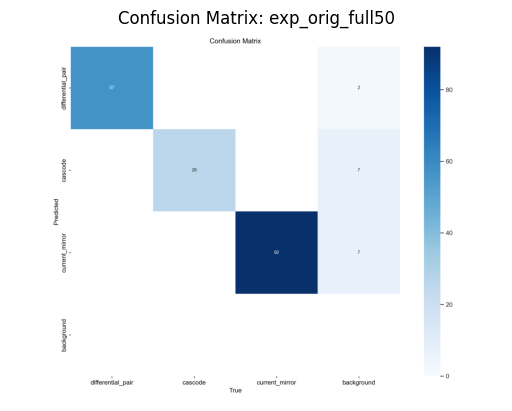

In [39]:
# Cell 12: Confusion matrix for exp_orig_full50
import matplotlib.pyplot as plt
import numpy as np

# Ultralytics auto-generates a confusion matrix plot to runs/detect/.../confusion_matrix.png
plt.imshow(plt.imread(proj_root/"runs"/"detect"/"exp_orig_full50"/"confusion_matrix.png"))
plt.axis("off")
plt.title("Confusion Matrix: exp_orig_full50")
plt.show()


=== Benchmark Training Metrics (exp_orig_full50) ===


,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
epoch,,,,,,,,,,,,,,
1,50.3747,2.70498,4.07132,2.26405,0.00584,0.08276,0.00400,0.00161,2.32454,4.38567,1.82067,0.000171,0.000171,0.000171
2,98.0600,2.04410,3.59251,1.74315,0.02403,0.09501,0.02425,0.00816,1.75709,3.16291,1.44464,0.000350,0.000350,0.000350
3,139.4840,1.65523,2.88494,1.46336,0.48376,0.11423,0.09335,0.05591,1.47048,2.38405,1.29559,0.000522,0.000522,0.000522
4,171.3480,1.56796,2.44849,1.38044,0.46102,0.09937,0.11234,0.06956,1.45216,1.89125,1.26663,0.000686,0.000686,0.000686
5,204.3380,1.47999,2.13315,1.34790,0.57193,0.12543,0.11760,0.07509,1.42604,1.91636,1.26332,0.000842,0.000842,0.000842


,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
epoch,,,,,,,,,,,,,,
46,2420.79,0.84995,0.63012,1.03293,0.93615,0.98718,0.98712,0.77336,0.74636,0.54271,0.97415,0.000156,0.000156,0.000156
47,2480.87,0.91328,0.67743,1.06311,0.93459,0.98718,0.98654,0.78037,0.73403,0.53730,0.96875,0.000127,0.000127,0.000127
48,2546.86,0.81205,0.60663,1.06059,0.95416,0.97765,0.98977,0.78706,0.70827,0.52769,0.96270,0.000099,0.000099,0.000099
49,2619.70,0.82274,0.61048,1.05476,0.94299,0.97771,0.98320,0.78191,0.70123,0.52775,0.96237,0.000071,0.000071,0.000071
50,2687.62,0.86583,0.72545,1.08417,0.95655,0.99364,0.98918,0.78833,0.69890,0.52424,0.96154,0.000043,0.000043,0.000043


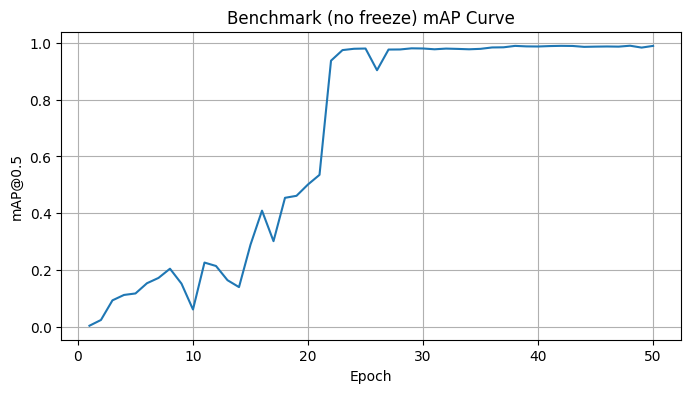

In [40]:
# Cell 10: Load & Display Training Metrics for the Benchmark

# 1) Load the epoch‐wise metrics for exp_orig_full50
df_bench = load_metrics("exp_orig_full50")

# 2) Show the first & last few rows so you can inspect convergence
print("=== Benchmark Training Metrics (exp_orig_full50) ===")
display(df_bench.head(), df_bench.tail())

# 3) (Optional) Plot its mAP curve for quick visual check
plt.figure(figsize=(8,4))
plt.plot(df_bench.index, df_bench["metrics/mAP50(B)"], label="benchmark mAP@0.5")
plt.xlabel("Epoch"); plt.ylabel("mAP@0.5")
plt.title("Benchmark (no freeze) mAP Curve"); plt.grid(True); plt.show()


In [44]:
# Cell Y: Final Test‐Set Evaluation Comparison

from ultralytics import YOLO
import pandas as pd

results = []
for tag, run_name in [("Stage1+2", run_stage2), ("One-Shot", run_bench)]:
    ckpt = get_checkpoint(run_name)
    model = YOLO(ckpt)
    print(f"▶️ Evaluating {tag} ({run_name}) on TEST split…")
    res = model.val(data=DATA_YAML, device=DEVICE, split="test", verbose=False)
    results.append({
        "model": tag,
        "test_mAP50":    float(res.box.map50),
        "test_mAP50-95": float(res.box.map),
        "Precision":     float(res.box.p.mean()),  # overall precision
        "Recall":        float(res.box.r.mean())   # overall recall
    })

# 3) Show side-by-side table
df_compare = pd.DataFrame(results).set_index("model")
display(df_compare)


▶️ Evaluating Stage1+2 (exp_stage2) on TEST split…
Ultralytics 8.3.122 🚀 Python-3.11.4 torch-2.6.0 MPS (Apple M4)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 37.8±9.0 MB/s, size: 8.3 KB)


val: Scanning /Users/fatihbasturk/Projects/EE58A-2025/subblock_detect/subblock_dataset/test/labels.cache... 103 images, 0 backgrounds, 0 corrupt: 100%|██████████| 103/103 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.49it/s]


                   all        103        180      0.971      0.933      0.974      0.729
Speed: 0.6ms preprocess, 6.6ms inference, 0.0ms loss, 15.1ms postprocess per image
Results saved to /Users/fatihbasturk/Projects/EE58A-2025/runs/detect/val25
▶️ Evaluating One-Shot (exp_orig_full50) on TEST split…
Ultralytics 8.3.122 🚀 Python-3.11.4 torch-2.6.0 MPS (Apple M4)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 523.6±147.8 MB/s, size: 10.1 KB)


val: Scanning /Users/fatihbasturk/Projects/EE58A-2025/subblock_detect/subblock_dataset/test/labels.cache... 103 images, 0 backgrounds, 0 corrupt: 100%|██████████| 103/103 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.32it/s]


                   all        103        180      0.947          1      0.985      0.771
Speed: 0.5ms preprocess, 5.9ms inference, 0.0ms loss, 9.4ms postprocess per image
Results saved to /Users/fatihbasturk/Projects/EE58A-2025/runs/detect/val26


,test_mAP50,test_mAP50-95,Precision,Recall
model,,,,
Stage1+2,0.974334,0.729204,0.970872,0.932804
One-Shot,0.984907,0.770971,0.946835,1.000000


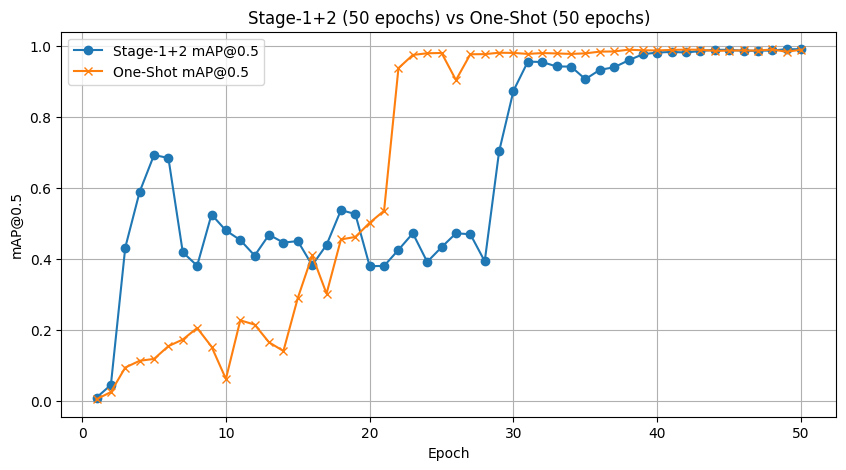

In [45]:
# Cell X: Plot Stage-1+2 (50 epochs) vs One-Shot (50 epochs)

import matplotlib.pyplot as plt
import pandas as pd

# Run names
run_stage1 = STAGE1_NAME       # e.g. "subblock_stage1_mps"
run_stage2 = STAGE2_NAME       # e.g. "subblock_stage2_mps"
run_bench  = "exp_orig_full50" # your one-shot run

# 1) Load metrics
df1 = load_metrics(run_stage1)              # head-only warmup epochs
df2 = load_metrics(run_stage2)              # full fine-tune epochs
df_b = load_metrics(run_bench)              # one-shot epochs

# 2) Offset Stage-2 epochs so they follow Stage-1
df2_off = df2.copy()
df2_off.index = df2_off.index + df1.index.max()

# 3) Concatenate the two-stage series
series_stage12 = pd.concat([
    df1["metrics/mAP50(B)"],
    df2_off["metrics/mAP50(B)"]
])

# 4) Plot
plt.figure(figsize=(10,5))
plt.plot(series_stage12.index, series_stage12.values, marker='o', label="Stage-1+2 mAP@0.5")
plt.plot(df_b.index, df_b["metrics/mAP50(B)"].values, marker='x', label="One-Shot mAP@0.5")
plt.xlabel("Epoch")
plt.ylabel("mAP@0.5")
plt.title("Stage-1+2 (50 epochs) vs One-Shot (50 epochs)")
plt.legend()
plt.grid(True)
plt.show()
